## MNIST Dataset Classification using LDA
### Summary

MNIST 데이터셋을 분류하기 위해 Linear Discriminant Analysis (LDA)를 사용.

Mnist 데이터셋을 이용하여 0부터 9까지의 10가지 손글씨 클래스를 구분한다. 

Time 측정 방법은 Method 측면에서는 
1. Model Fitting Time : KNN의 경우 데이터셋에 대한 Checking 및 데이터셋 메모리에 카피
2. All Test Data Prediction Time
3. One Instance Prediction Time 10번 평균

PCA 측면에서는 
1. Calculate Train Data SVD Matrix Time
2. Transform Train X to N-PCA Time
3. Transform Test X to N-PCA Time

LDA 측면에서는 
1. Calculate Train Data LDA Matrix Time
2. Transform Train X to N-LDA Time
3. Transform Test X to N-LDA Time

### Table of Contents

* [Load MNIST Dataset](#load-mnist-dataset)
  * [Sample Images](#sample-images)
  * [Train & Test Data Label Distribution](#train--test-data-label-distribution)
  * [Preprocessing](#preprocessing)
* [Linear Discriminant Analysis (LDA)](#linear-discriminant-analysis-lda)
  * [LDA run function](#lda-run-function)
  * [1 개의 Instance 예측하는데 걸리는 시간 측정](#1개의-instance를-예측하는데-걸리는-시간-측정---10번-반복)
* [PCA run function](#pca-run-function)
  * [PCA feature 2](#pca-feature-2)
  * [PCA feature 3](#pca-feature-3)
  * [PCA feature 5](#pca-feature-5)
  * [PCA feature 26](#pca-feature-26)
  * [PCA feature 43](#pca-feature-43)
* [LDA Dimension Reduction run function](#lda-dimension-reduction-run-function)
  * [LDA feature 2](#lda-feature-2)
  * [LDA feature 3](#lda-feature-3)
  * [LDA feature 5](#lda-feature-5)
  * [LDA feature 9](#lda-feature-9)

In [1]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [12]:
class BaseConfig:
    def __init__(self):
        pass

    def info(self):
        config_list = {
            0 : ['Dataset', self.dataset, 
                 "Train size: " + str(int((1-self.test_size)*100))+"%",
                 'Feature size: ' + str(self.feature_size), 1],
            1 : ['Method', self.method, 
                 "k = " + str(self.k), self.distance, 2],
            2 : ['Dimension reduction', 
                 'Method: ' + str(self.reduction_method[0]),
                 'Component size: ' + str(self.reduction_method[1]),
                 'Feature Reduction Ratio: ' + \
                    str(round(self.reduction_method[1]/self.feature_size, 3)*100 if self.reduction_method[1] is not None else None)+"%", 3],
            3 : ['Iteration', str(self.iter), -1]
        }

        print("Device " + "─" * 2 + " " + self.device)
        print("│")

        parent = 1
        for child in range(len(config_list)):
            for idx, contents in enumerate(config_list[child][:-1]):
                if idx == 0 and child == len(config_list)-1:
                    print("└" + "─" * 2 + contents)
                elif idx == 0:
                    print("├" + "─" * 2 + contents)
                elif child == len(config_list)-1:
                    print(" " * 4 + "└" + "─" * 4 + contents)
                else:
                    print("│" + " " * 4 + "└" + "─" * 4 + contents)
            parent = config_list[child][-1]
            if parent == -1: break
            print("│")

    def print_rutin(self):
        if self.reduction_method[0] is None:
            rutin = str(self.device) + " - " + str(self.dataset) + "(" + str(int((1-self.test_size)*100)) + "%) - " + str(self.method) + " - " + str(self.iter) + " iteration"
            print(rutin)
        else:
            rutin = str(self.device) + " - " + str(self.dataset) + "(" + str(int((1-self.test_size)*100)) + "%) - " + str(self.method) + " - " + str(self.iter) + " iteration - " + str(self.reduction_method[0]) + "(feature " + str(self.reduction_method[1]) + ")"
            print(rutin)

class Config(BaseConfig):
    def __init__(self):
        super(BaseConfig, self).__init__()
        self.device = 'PC'
        self.dataset = 'Mnist'
        self.test_size = 0.2
        self.feature_size = 784
        self.method = 'LDA'
        self.k = None
        self.distance = ''
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10


## Load Mnist Dataset

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])

batch_size = 512

trainset = MNIST(root='../../datasets', train=True, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validationset = MNIST(root='../../datasets', train=False, download=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2)

print(trainset.data.shape)
print(validationset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


c:\Users\Cau_13\Anaconda3\envs\tf-venv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_mnist = MNIST(root='../../datasets', train=True, download=False)
test_mnist = MNIST(root='../../datasets', train=False, download=False)

In [6]:
train_mnist_X, train_mnist_y = train_mnist.data.numpy(), train_mnist.targets.numpy()
test_mnist_X, test_mnist_y = test_mnist.data.numpy(), test_mnist.targets.numpy()

print(f'Train data X shape : {train_mnist_X.shape}, y shape : {train_mnist_y.shape}')
print(f'Test data X shape : {test_mnist_X.shape}, y shape : {test_mnist_y.shape}')

Train data X shape : (60000, 28, 28), y shape : (60000,)
Test data X shape : (10000, 28, 28), y shape : (10000,)


In [7]:
print(f'Mnist Data range [{train_mnist_X.min()}, {train_mnist_X.max()}] ')

train_mnist_X, test_mnist_X = train_mnist_X / 255., test_mnist_X / 255.

print(f'--> Mnist Data Normalized range [{train_mnist_X.min()}, {train_mnist_X.max()}] ')

Mnist Data range [0, 255] 
--> Mnist Data Normalized range [0.0, 1.0] 


## Sample Images

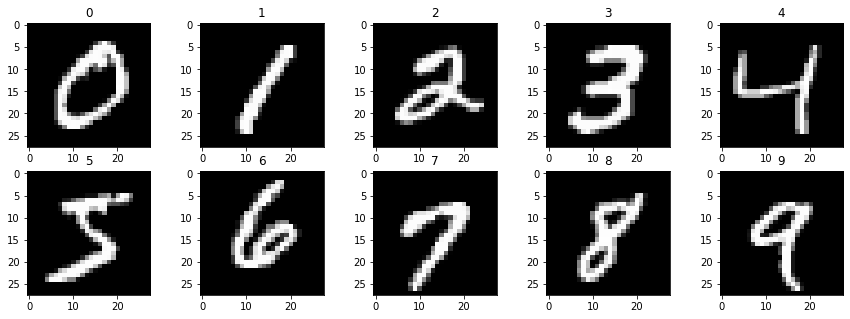

In [8]:
plt.figure(figsize=(15, 5))

for i in range(10):
    sample_idx = np.where(train_mnist_y == i)[0][0]

    sample_image = train_mnist_X[sample_idx]
    sample_label = train_mnist_y[sample_idx]

    plt.subplot(2, 5, i+1) # nrows, ncolumns, index
    plt.title(sample_label)
    plt.imshow(sample_image,'gray')
plt.show()

## Train & Test Data Label Distribution

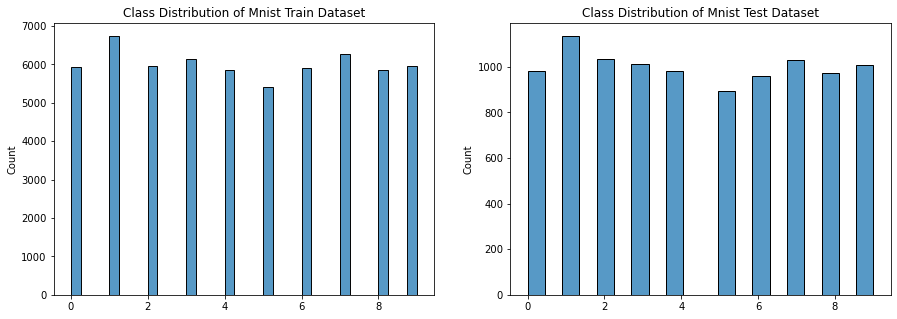

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_mnist_y, palette="tab10")
plt.title("Class Distribution of Mnist Train Dataset")

plt.subplot(1, 2, 2)
sns.histplot(test_mnist_y, palette="tab10")
plt.title("Class Distribution of Mnist Test Dataset")
plt.show()

## Preprocessing
 * Flatten 28 x 28 images to 784 vectors

In [10]:
print(f'Mnist Data shape train : {train_mnist_X.shape}, test : {test_mnist_X.shape}')

train_mnist_X = train_mnist_X.reshape(-1, 784)
test_mnist_X = test_mnist_X.reshape(-1, 784)

print(f'--> Mnist Data shape train : {train_mnist_X.shape}, test : {test_mnist_X.shape}')

Mnist Data shape train : (60000, 28, 28), test : (10000, 28, 28)
--> Mnist Data shape train : (60000, 784), test : (10000, 784)


## Linear Discriminant Analysis (LDA)

In [13]:
config = Config()
config.info()

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


### LDA run function

In [44]:
def lda_run(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            test_data_y = test_mnist_y,
            config = None):

    assert config is not None
    # config.info()
    config.print_rutin()
    max_seed = config.iter

    avg_test_acc = []
    avg_lda_fit_time = []
    avg_pred_time = []
    preds = []

    for seed in tqdm(range(max_seed)):
        x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

        lda = LinearDiscriminantAnalysis()

        start_time = time.perf_counter()
        lda.fit(x_train, y_train)
        lda_fit_time = time.perf_counter() - start_time
        avg_lda_fit_time.append(lda_fit_time)

        start_time = time.perf_counter()
        pred = lda.predict(x_test)
        pred_time = time.perf_counter() - start_time
        preds.append(pred)

        test_score = accuracy_score(pred, y_test)
        avg_test_acc.append(test_score)
        avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", len(x_test))
    print("-----" * 8)
    print("Test set score: %.4f ± %.5f" % (np.array(avg_test_acc).mean(), np.array(avg_test_acc).std()))
    print("LDA fitting Time: %.5f ± %.6f" % (np.array(avg_lda_fit_time).mean(), np.array(avg_lda_fit_time).std()), "sec")
    print("All Test dataset Prediction Time at once : %.7f ± %.8f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")
    print("Divide the Prediction Time by Test size : %.9f ± %.9f" % (np.array(avg_pred_time).mean()/len(x_test), np.array(avg_pred_time).std()/len(x_test)), "sec")

    return avg_test_acc, avg_lda_fit_time, avg_pred_time

In [18]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration


100%|██████████| 10/10 [00:40<00:00,  4.09s/it]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8730 ± 0.00000
LDA fitting Time: 4.06746 ± 0.053026 sec
All Test dataset Prediction Time at once : 0.0191610 ± 0.00139812 sec
Divide the Prediction Time by Test size : 0.000001916 ± 0.000000140 sec


### 1개의 Instance를 예측하는데 걸리는 시간 측정 - 10번 반복

In [20]:
def lda_run_one_instance(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            test_data_y = test_mnist_y,
            config = None):

    assert config is not None
    # config.info()
    config.print_rutin()
    max_seed = config.iter


    x_train, x_test, y_train, y_test = train_data_X, test_data_X, train_data_y, test_data_y

    lda = LinearDiscriminantAnalysis()

    start_time = time.perf_counter()
    lda.fit(x_train, y_train)
    lda_fit_time = time.perf_counter() - start_time

    avg_pred_time = []
    preds = []
    ys_test = []
    count = 0

    for x_one, y_one in tqdm(zip(x_test, y_test)):
        x_one = x_one.reshape(1, -1)

        start = time.perf_counter()
        pred = lda.predict(x_one)
        pred_time = time.perf_counter() - start
        

        avg_pred_time.append(pred_time)
        preds.append(pred)
        ys_test.append(y_one)

        count += 1
        if count == 10:
            break

    test_score = accuracy_score(preds, ys_test)
    avg_test_acc.append(test_score)
    avg_pred_time.append(pred_time)

    print("Train size : ", len(x_train), " / Test size : ", 10)
    print("-----" * 8)
    print("Test set score: %f" % np.array(avg_test_acc).mean())
    print("LDA fitting Time: %.7f" % (lda_fit_time), "sec")
    print("One Instance Prediction Average Time : %.9f ± %.9f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")

    return avg_test_acc, lda_fit_time, avg_pred_time

In [21]:
avg_test_acc, knn_fit_time, avg_pred_time = lda_run_one_instance(train_data_X = train_mnist_X,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_mnist_X,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration


9it [00:00, 8987.79it/s]

Train size :  60000  / Test size :  10
----------------------------------------
Test set score: 0.884545
LDA fitting Time: 4.0216707 sec
One Instance Prediction Average Time : 0.000056973 ± 0.000029262 sec


## PCA run function

In [22]:
def pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=None):

    assert config is not None
    config.info()

    n_components = config.reduction_method[1]

    pca_dims = PCA(n_components)
    print(f"The number of components : {n_components}")

    start_time = time.perf_counter()
    pca_dims.fit(train_data_X)
    pca_fit_time = time.perf_counter () - start_time
    print()
    print(f"Calculating SVD Matrix Time on Train Data-{train_data_X.shape} : {pca_fit_time:4f} sec")
    
    start_time = time.perf_counter()
    train_features = pca_dims.transform(train_data_X)
    train_features_extract_time = time.perf_counter () - start_time
    print(f"Transform train X-{train_data_X.shape} to {n_components}-PCA Time: {train_features_extract_time:4f} sec")

    start_time = time.perf_counter()
    test_features = pca_dims.transform(test_data_X)
    test_features_extract_time = time.perf_counter () - start_time
    print(f"Transform test X-{train_data_X.shape} to {n_components}-PCA Time: {test_features_extract_time:4f} sec")

    return pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time
    

In [23]:
n_components_list = []
pca_fit_time_list = []
train_features_extract_time_list = []
test_features_extract_time_list = []

### PCA feature 2

In [24]:
config.reduction_method = ['PCA', 2]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.3%
│
└──Iteration
    └────10
The number of components : 2

Calculating SVD Matrix Time on Train Data-(60000, 784) : 0.868509 sec
Transform train X-(60000, 784) to 2-PCA Time: 0.135040 sec
Transform test X-(60000, 784) to 2-PCA Time: 0.024103 sec


* 2 PCA features - LDA run

In [25]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - PCA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 45.05it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4429 ± 0.00000
LDA fitting Time: 0.01845 ± 0.003086 sec
All Test dataset Prediction Time at once : 0.0031661 ± 0.00770763 sec
Divide the Prediction Time by Test size : 0.000000317 ± 0.000000771 sec


### PCA feature 3

In [26]:
config.reduction_method = ['PCA', 3]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.4%
│
└──Iteration
    └────10
The number of components : 3

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.025415 sec
Transform train X-(60000, 784) to 3-PCA Time: 0.130769 sec
Transform test X-(60000, 784) to 3-PCA Time: 0.023874 sec


* 3 PCA features - LDA run

In [27]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - PCA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 37.59it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.4660 ± 0.00000
LDA fitting Time: 0.02531 ± 0.003723 sec
All Test dataset Prediction Time at once : 0.0007214 ± 0.00006184 sec
Divide the Prediction Time by Test size : 0.000000072 ± 0.000000006 sec


### PCA feature 5

In [28]:
config.reduction_method = ['PCA', 5]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 5
│    └────Feature Reduction Ratio: 0.6%
│
└──Iteration
    └────10
The number of components : 5

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.148378 sec
Transform train X-(60000, 784) to 5-PCA Time: 0.136307 sec
Transform test X-(60000, 784) to 5-PCA Time: 0.029474 sec


* 5 PCA features - LDA run

In [29]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - PCA(feature 5)


100%|██████████| 10/10 [00:00<00:00, 30.86it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.6649 ± 0.00000
LDA fitting Time: 0.03106 ± 0.004064 sec
All Test dataset Prediction Time at once : 0.0006992 ± 0.00006726 sec
Divide the Prediction Time by Test size : 0.000000070 ± 0.000000007 sec


### PCA feature 26

In [30]:
config.reduction_method = ['PCA', 26]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 26
│    └────Feature Reduction Ratio: 3.3000000000000003%
│
└──Iteration
    └────10
The number of components : 26

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.060553 sec
Transform train X-(60000, 784) to 26-PCA Time: 0.190896 sec
Transform test X-(60000, 784) to 26-PCA Time: 0.034739 sec


* 26 PCA features - LDA run

In [31]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - PCA(feature 26)


100%|██████████| 10/10 [00:01<00:00,  7.89it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8573 ± 0.00000
LDA fitting Time: 0.12441 ± 0.015050 sec
All Test dataset Prediction Time at once : 0.0011601 ± 0.00012171 sec
Divide the Prediction Time by Test size : 0.000000116 ± 0.000000012 sec


### PCA feature 43

In [32]:
config.reduction_method = ['PCA', 43]

pca_dims, train_features, test_features, pca_fit_time, train_features_extract_time, test_features_extract_time = \
    pca_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
pca_fit_time_list.append(pca_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 43
│    └────Feature Reduction Ratio: 5.5%
│
└──Iteration
    └────10
The number of components : 43

Calculating SVD Matrix Time on Train Data-(60000, 784) : 1.499132 sec
Transform train X-(60000, 784) to 43-PCA Time: 0.198164 sec
Transform test X-(60000, 784) to 43-PCA Time: 0.035455 sec


* 43 PCA features - LDA run

In [33]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - PCA(feature 43)


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8720 ± 0.00000
LDA fitting Time: 0.20086 ± 0.016909 sec
All Test dataset Prediction Time at once : 0.0015270 ± 0.00022371 sec
Divide the Prediction Time by Test size : 0.000000153 ± 0.000000022 sec


## LDA Dimension Reduction run function

In [41]:
def lda_dim_reduce_run(train_data_X = train_mnist_X,
            train_data_y = train_mnist_y,
            test_data_X = test_mnist_X,
            config=None):

    assert config is not None
    config.info()

    n_components = config.reduction_method[1]

    lda_dims = LinearDiscriminantAnalysis(n_components=n_components)
    print(f"The number of components : {n_components}")

    start_time = time.perf_counter()
    lda_dims.fit(train_data_X, train_data_y)
    lda_fit_time = time.perf_counter () - start_time
    print()
    print(f"Calculating LDA Matrix Time on Train Data-{train_data_X.shape} : {lda_fit_time:4f} sec")
    
    start_time = time.perf_counter()
    train_features = lda_dims.transform(train_data_X)
    train_features_extract_time = time.perf_counter () - start_time
    print(f"Transform train X-{train_data_X.shape} to {n_components}-LDA Time: {train_features_extract_time:4f} sec")

    start_time = time.perf_counter()
    test_features = lda_dims.transform(test_data_X)
    test_features_extract_time = time.perf_counter () - start_time
    print(f"Transform test X-{train_data_X.shape} to {n_components}-LDA Time: {test_features_extract_time:4f} sec")

    return lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time

In [42]:
n_components_list = []
lda_fit_time_list = []
train_features_extract_time_list = []
test_features_extract_time_list = []

### LDA feature 2

In [43]:
config.reduction_method = ['LDA', 2]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_dim_reduce_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.3%
│
└──Iteration
    └────10
The number of components : 2

Calculating LDA Matrix Time on Train Data-(60000, 784) : 4.043318 sec
Transform train X-(60000, 784) to 2-LDA Time: 0.163304 sec
Transform test X-(60000, 784) to 2-LDA Time: 0.025337 sec


* 2 LDA features - LDA run

In [45]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - LDA(feature 2)


100%|██████████| 10/10 [00:00<00:00, 50.00it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.5413 ± 0.00000
LDA fitting Time: 0.01888 ± 0.003517 sec
All Test dataset Prediction Time at once : 0.0005982 ± 0.00005116 sec
Divide the Prediction Time by Test size : 0.000000060 ± 0.000000005 sec


### LDA feature 3

In [46]:
config.reduction_method = ['LDA', 3]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_dim_reduce_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.4%
│
└──Iteration
    └────10
The number of components : 3

Calculating LDA Matrix Time on Train Data-(60000, 784) : 3.969281 sec
Transform train X-(60000, 784) to 3-LDA Time: 0.138923 sec
Transform test X-(60000, 784) to 3-LDA Time: 0.026120 sec


* 3 LDA features - LDA run

In [47]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - LDA(feature 3)


100%|██████████| 10/10 [00:00<00:00, 41.67it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.7273 ± 0.00000
LDA fitting Time: 0.02269 ± 0.003671 sec
All Test dataset Prediction Time at once : 0.0007002 ± 0.00010844 sec
Divide the Prediction Time by Test size : 0.000000070 ± 0.000000011 sec


### LDA feature 5

In [48]:
config.reduction_method = ['LDA', 5]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_dim_reduce_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 5
│    └────Feature Reduction Ratio: 0.6%
│
└──Iteration
    └────10
The number of components : 5

Calculating LDA Matrix Time on Train Data-(60000, 784) : 4.011894 sec
Transform train X-(60000, 784) to 5-LDA Time: 0.156159 sec
Transform test X-(60000, 784) to 5-LDA Time: 0.027104 sec


* 5 LDA features - LDA run

In [49]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - LDA(feature 5)


100%|██████████| 10/10 [00:00<00:00, 29.85it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8135 ± 0.00000
LDA fitting Time: 0.03203 ± 0.005032 sec
All Test dataset Prediction Time at once : 0.0007808 ± 0.00005942 sec
Divide the Prediction Time by Test size : 0.000000078 ± 0.000000006 sec


### LDA feature 9

In [50]:
config.reduction_method = ['LDA', 9]

lda_dims, train_features, test_features, lda_fit_time, train_features_extract_time, test_features_extract_time = \
    lda_dim_reduce_run(train_data_X = train_mnist_X,
            test_data_X = test_mnist_X,
            config=config)

n_components_list.append(config.reduction_method[1])
lda_fit_time_list.append(lda_fit_time)
train_features_extract_time_list.append(train_features_extract_time)
test_features_extract_time_list.append(test_features_extract_time)

Device ── PC
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────LDA
│    └────k = None
│    └────
│
├──Dimension reduction
│    └────Method: LDA
│    └────Component size: 9
│    └────Feature Reduction Ratio: 1.0999999999999999%
│
└──Iteration
    └────10
The number of components : 9

Calculating LDA Matrix Time on Train Data-(60000, 784) : 4.083448 sec
Transform train X-(60000, 784) to 9-LDA Time: 0.151158 sec
Transform test X-(60000, 784) to 9-LDA Time: 0.025879 sec


* 9 LDA features - LDA run

In [51]:
avg_test_acc, avg_knn_fit_time, avg_pred_time = lda_run(train_data_X = train_features,
                                                        train_data_y = train_mnist_y,
                                                        test_data_X = test_features,
                                                        test_data_y = test_mnist_y,
                                                        config = config)

PC - Mnist(80%) - LDA - 10 iteration - LDA(feature 9)


100%|██████████| 10/10 [00:00<00:00, 19.92it/s]

Train size :  60000  / Test size :  10000
----------------------------------------
Test set score: 0.8730 ± 0.00000
LDA fitting Time: 0.04863 ± 0.006027 sec
All Test dataset Prediction Time at once : 0.0008727 ± 0.00007757 sec
Divide the Prediction Time by Test size : 0.000000087 ± 0.000000008 sec
